# Lecture 11 - A/B Testing

This notebook will show you how to perform A/B testing on Twitter data.

Below is the overview of this notebook.

<ol type = 1>
    <li> Favorite Count vs Keyword</li>
    <ol type = 1>
      <li> T-test</li>
      <li> Mann-Whitney U test</li>
      <li> Kolmogorov- Smirnov test</li>
      <li> Multiple Hypotheses</li>
    </ol>
    <li> Comparing Users</li>
    <ol type = 1>
      <li> Language (Fisher Exact Test)</li>    
      <li> Engagement (t-test)</li>
      <li> Engagement vs keywords (multiple hypotheses)</li>
</ol>

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.




# Clones, installs, and imports


## Clone Repo


In [1]:
# Clone GitHub repository
!git clone https://github.com/zlisto/social_media_genAI

import os
os.chdir("social_media_genAI/main")

Cloning into 'social_media_genAI'...
remote: Enumerating objects: 2109, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 2109 (delta 24), reused 54 (delta 18), pack-reused 2049 (from 4)
Receiving objects: 100% (2109/2109), 290.81 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Updating files: 100% (1632/1632), done.


## Installs

In [2]:
!pip install -q -r requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 24.12.0 requires networkx>=3.2, but you have networkx 3.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.

## Import Packages



In [3]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests
import re
#helper functions for using ChatGPT
from scripts.genai import GenAI

#this option makes it so tweets display nicely in a dataframe
pd.set_option("display.max_colwidth", None)

#this code sets the font sizes for plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'figure.figsize':(8,6),
                     'axes.grid':True})

# Favorite Count vs. Keyword

We will look at the tweets of a single user and compare favorite counts versus keywords.

## Load data

The data is in `"data/tweets_trump_01-08-2021.csv"`. Load it into a dataframe `df` and display the head of the dataframe so you can see the column names and values.

In [8]:
fname = "data/tweets_trump_01-08-2021.csv"
df = pd.read_csv(fname, on_bad_lines='skip')
df['datetime'] = pd.to_datetime(df['date'])
df = df.set_index('datetime')
df = df.sort_index()
ntweets = len(df)
print(f"dataframe has {ntweets:,} tweets")
display(df.head())

dataframe has 56,571 tweets


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
datetime,,,,,,,,,
2009-05-04 18:54:25,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!,f,f,Twitter Web Client,939,519,2009-05-04 18:54:25,f
2009-05-05 01:00:10,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!,f,f,Twitter Web Client,259,34,2009-05-05 01:00:10,f
2009-05-08 13:38:08,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman: http://tinyurl.com/ooafwn - Very funny!,f,f,Twitter Web Client,37,15,2009-05-08 13:38:08,f
2009-05-08 20:40:15,1741160716,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way: http://tinyurl.com/qlux5e,f,f,Twitter Web Client,29,11,2009-05-08 20:40:15,f
2009-05-12 14:07:28,1773561338,"""""""My persona will never be that of a wallflower - I’d rather build walls than cling to them"""" --Donald J. Trump""",f,f,Twitter Web Client,1877,1321,2009-05-12 14:07:28,f


## Add keyword indicator column

We will define a list of keywords.  Then we will add a column to the dataframe called `f"keyword_{keyword}"` that tells us if the tweet contains the keyword.  

In [9]:
keywords = ['trump', 'biden',
            'america', 'maga']

for keyword in keywords:
    col = f'keyword_{keyword}'
    ind = df['text'].str.contains(keyword, case=False, regex=True, na=False)
    df[col] = ind

    ntweets = ind.sum()
    print(f"Keyword '{keyword}' is in {ntweets:,}/{len(df):,} tweets")

df.sample(n=2)


Keyword 'trump' is in 18,356/56,571 tweets
Keyword 'biden' is in 1,115/56,571 tweets
Keyword 'america' is in 5,008/56,571 tweets
Keyword 'maga' is in 821/56,571 tweets


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,keyword_trump,keyword_biden,keyword_america,keyword_maga
datetime,,,,,,,,,,,,,
2014-11-30 04:46:38,538916993014169600,"""""""@JHasseyjr: """"@abunnieslife: Mr Trump we had the honor of visiting your beautiful tower in Chicago You own a grand building sir! Thank""""""",f,f,Twitter for Android,47,23,2014-11-30 04:46:38,f,True,False,False,False
2017-10-05 01:08:28,915745470689005573,"On behalf of a GRATEFUL NATION, THANK YOU to all of the First Responders (HEROES) who saved countless lives in Las Vegas on Sunday night. https://t.co/ZxuMYWnNHv",f,f,Twitter for iPhone,95057,18869,2017-10-05 01:08:28,f,False,False,False,False


## Plot favorites for each keyword


We will plot the `"favorites"` vs. `"keyword_<keyword>"` with the `barplot` function and set the confidence intervals with the `errorbar` parameter.  This will let us see visually which keywords have a higher mean favorite count.

<Figure size 1600x800 with 0 Axes>

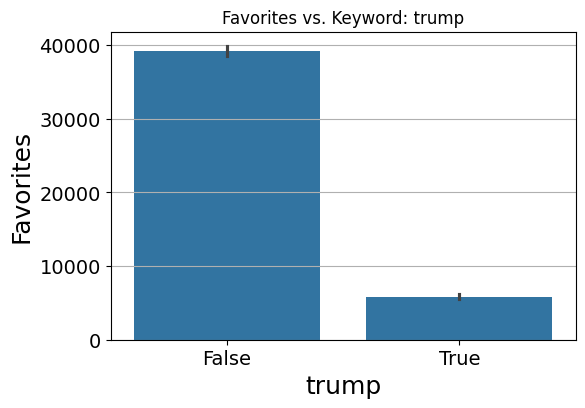

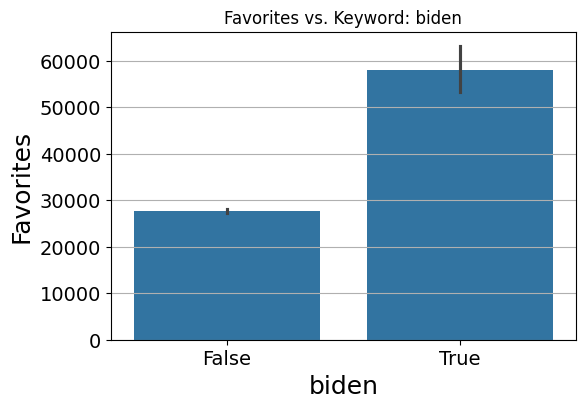

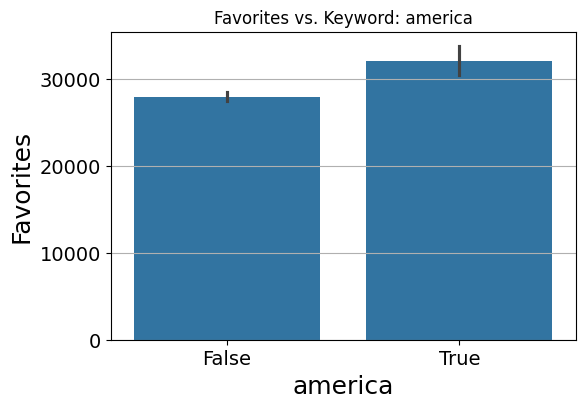

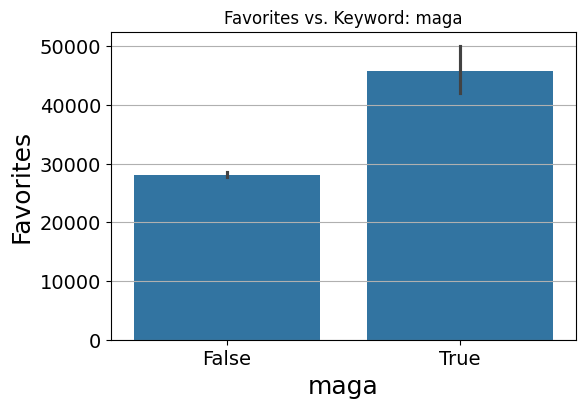

In [10]:
plt.figure(figsize=(16, 8))  # Adjust figure size for better visualization

for keyword in keywords:
    col = f'keyword_{keyword}'
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df,
                x=col,
                y='favorites',
                errorbar=("ci", 95))
    plt.title(f'Favorites vs. Keyword: {keyword}')
    plt.xlabel(keyword)
    plt.ylabel('Favorites')
    plt.show()


## Create Data for Statistical Tests

We will created arrays `X0` and `X1` that are the favorite counts without  and with a keyword.

In [12]:
keyword = 'america'
col = f"keyword_{keyword}"

X0 = df.loc[~df[col], 'favorites'].values  #dont have keyword
X1 = df.loc[df[col], 'favorites'].values   #have keyword



## Statistical Tests

We will conduct a variety of statistical tests on `X0` and `X1` to see if they are different.  The statistical tests we use have similar structure.  They each return the test statistic and the p-value.  They let us specify what alternative hypothesis we are looking for using the  `alternative` parameter. Its value can be set to

1. `'two-sided'` = means are different

2. `'less'` = mean of first argument is less than second argument

3. `'greater'` = mean of first argument is greater than second argument

We can set our significance level `alpha` to determine if we deem the test significant or not.  Significant means `pval<=alpha`.

### T-test

We can apply the t-test to compare the mean favorite counts.  The t-test is appropriate when the variance is unknown.  We use the function `ttest_ind` and set `equal_var=False`.

In [16]:
alpha = 0.01  #significance level

(tstat, pval) =stats.ttest_ind(X0,X1,
                               equal_var = False,
                               nan_policy = 'omit',
                               alternative = 'two-sided')

print('T-test')
print(f"{keyword}: t-stat = {tstat:.3f} ({pval:.3e})")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

T-test
america: t-stat = -4.711 (2.525e-06)
Significant at 1% level


### Mann-Whitney U test

The Mann-Whitney U test is a non-parametric test that deals with the probability
$$\mathbf P(X_1>X_0).$$  

We use the `mannwhitneyu` function.

In [18]:
alpha = 0.01  #significance level

ustat, pval = stats.mannwhitneyu(X0, X1,
                                nan_policy = 'omit',
                                alternative = 'two-sided')

print('Mann Whitney U test')
print(f"{keyword}: U-stat = {ustat:,.3f} ({pval:.3e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Mann Whitney U test
america: U-stat = 117,146,379.000 (1.377e-27)

Significant at 1% level


### Kolmogorov-Smirnov test

The Kolmogorov-Smirnov test is a non-parametric test with the null hypothesis that the cumulative distribution functions of the two groups are equal.  We use the `ks_2samp` function.


In [19]:
alpha = 0.01  #significance level

ksstat, pval = stats.ks_2samp(X0, X1,
                              nan_policy = 'omit',
                              alternative='two-sided')

print('Kolmogorov-Smirnov test')
print(f"{keyword}: KS-stat = {ustat:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

Kolmogorov-Smirnov test
america: KS-stat = 117146379.000 (3.108e-82)

Significant at 1% level


## Multiple Hypotheses

If we test all the keywords to see which ones increase the mean favorite count, we need to correct the p-values to account for the multiple hypotheses.  We first choose a significance level `alpha`, which is either the family-wise error rate (FWER) or the false discovery rate (FDR).  Then we calculate the p-value of a t-test (or any test you want to use) for each keyword and save these p-values in a list `pvals`.  Finally, we apply the `multipletests` function to `pvals` and set `method` to our method of choice.  We save the results in a dataframe `df_p` so we can read the results easily.



### Calculate P-Values

First we need to choose a test and calculate the p-values for each keyword and save the result to a list `pvals`.  For the tests your can choose:

1. `ttest_ind` = t-Test

2. `mannwhitneyu` = Mann-Whitney U-Test

3. `ks_2samp` = Kolmogorov-Smirnov Test

In [21]:
pvals = []
col = 'favorites'
for keyword in keywords:
  ind = df[f"keyword_{keyword}"]==True
  X0 = df.loc[~ind,col].dropna().to_numpy()
  X1 = df.loc[ind,col].dropna().to_numpy()
  (tstat, pval) =stats.mannwhitneyu(X0,X1)
  pvals.append(pval)
  print(f"{keyword}: stat = {tstat:.3f} ({pval:.3e})")

pvals

trump: stat = 491313991.000 (0.000e+00)
biden: stat = 32428705.500 (4.953e-03)
america: stat = 117146379.000 (1.377e-27)
maga: stat = 17221233.000 (2.008e-34)


[0.0, 0.004952973920894582, 1.3772449859691654e-27, 2.0081468208916627e-34]

### Apply `multipletests`

Select a multiple hypothesis `method` to your method.  Your choices are

1. `'bonferroni'` = Bonferroni method (FWER)

2. `'sidak'` = Sidak method (FWER)

3. `'holm'` = Holm-Bonferroni method (FWER)

4. `'fdr_bh'` = Benjamini-Hochberg method (FDR)

In [23]:
alpha = 0.01  #significance level
#multiple testing method, choices are
#'bonferroni', 'sidak', 'holm', or 'fdr_bh'
method = 'bonferroni'
rejects, pvals_corrected, _, _ = multipletests(pvals,
                                            alpha=alpha,
                                            method=method,
                                            is_sorted=False,
                                            returnsorted=False)
df_p = pd.DataFrame({'keyword':keywords,
                     'reject_H0':rejects,
                     'pval':pvals,
                     'pvals_corrected':pvals_corrected})
print(f"{method} method")
df_p

bonferroni method


,keyword,reject_H0,pval,pvals_corrected
0,trump,True,0.000000e+00,0.000000e+00
1,biden,False,4.952974e-03,1.981190e-02
2,america,True,1.377245e-27,5.508980e-27
3,maga,True,2.008147e-34,8.032587e-34


# Comparing Users

We will compare two Twitter users tweeting language and engagement.

## Load data

Let's compare the tweets of ElonMusk and XXX.  The data files are

1. `"data/TwExportly/TwExportly_joebiden_tweets_2024_02_20.csv"`
2. `"data/TwExportly/TwExportly_kamalaharris_tweets_2024_02_20.csv"`

Load these into a dataframe and add a column `"username"` which is their Twitter usernames.  You can use a regular expression (`re`) to get the username from the filename.  Ask AI for help.

In [24]:
filenames = []
filenames.append("data/TwExportly/TwExportly_kamalaharris_tweets_2024_02_20.csv")
filenames.append("data/TwExportly/TwExportly_joebiden_tweets_2024_02_20.csv")

df_list = []
for filename in filenames:
  df_temp = pd.read_csv(filename)
  match = re.search(r"TwExportly_(.*?)_tweets", filename)
  username = match.group(1)
  df_temp['username'] = username
  df_list.append(df_temp)

df = pd.concat(df_list, axis=0)
df[['username','text','favorite_count','view_count']]

,username,text,favorite_count,view_count
0,kamalaharris,".@JoeBiden got us back on track from the failures of the last administration.\n\nHe built an economy that works for everyone and created nearly 15 million jobs along the way.\n\nHe didn’t just talk about infrastructure week, he passed historic bipartisan legislation to rebuild our nation’s crumbling infrastructure. He didn’t sit back and say Americans should get over gun violence, he took on the gun lobby and passed the first bipartisan gun legislation in 30 years.\n\nThat’s leadership.",2730,152587.0
1,kamalaharris,We are bringing manufacturing back to America. https://t.co/6w9fvWLTcF,2597,184934.0
2,kamalaharris,"Meet the speakers from our most anticipated panel at #FIIPRIORITY #Miami: The Board of Changemakers!\nDiscover their insights on navigating the complex interplay between the latest business trends &amp; regional outlooks, which will significantly influence the global economy in 2024. https://t.co/inOTdhxtgH",31,329267.0
3,kamalaharris,"It was an honor to represent the U.S. at the Munich Security Conference for the third year.\n\nPresident Biden and I are committed to working with our allies and partners to ensure global stability and prosperity. This approach makes America strong, and it keeps Americans safe. https://t.co/wrJ7QHut3z",6952,514773.0
4,kamalaharris,"Over the past three years, President Biden and I have: \n\nCreated more than 14 million new jobs. \nIncreased wages for tens of millions of Americans. \nLowered costs for families.\n\nWe have more work to do, but it's clear: America's economy is strong and getting stronger. https://t.co/lVxYlflCi5",17641,629570.0
...,...,...,...,...
998,joebiden,"Americans want lawmakers to act on commonsense gun safety reforms. Instead, this past week, Americans saw national Republican elected leaders stand alongside the NRA in a race to the bottom on dangerous laws that further erode gun safety.\n\nOur communities need and deserve better.",5940,987944.0
999,joebiden,"Guns are the leading killer of children in America, and the numbers are rising.\n\nWhat has our nation come to when children cannot attend a birthday party without fear? When parents have to worry every time their kids walk out the door to school, the movie theater, or to the park?",13141,2316412.0
1000,joebiden,Ban assault weapons.\nRequire safe storage of firearms. \nRequire background checks for all gun sales. \nEliminate gun manufacturers’ immunity from liability.\n\nWe can and must do these things now.,36317,6429171.0
1001,joebiden,I’m so grateful for the continued leadership of @KamalaHarris. https://t.co/bFUxenO88R,16702,2635213.0


## Language Usage

We will first compare differences in the tweet language.  Specifically, who uses certain keywords more.

### Contingency table

We select a keyword `keyword`.  Then we calculate the contingency table for this data using the `pd.crosstab` function, where we give it the `screen_name` column and a column that is `True` or `False` if `text` contains `keyword`..  The table has the values `a`,`b`,`c`,`d` which indicate the number of tweets in each category as follows:

|Has keyword |User 0 | User 1|
|-|--------|------|
|True | a| b|
|False| c|d|

We store the table as a list of lists in `contingency_table`.

In [30]:
keyword ='America'  #you can pick any keyword you like, not just the ones in the keywords list
df[f'keyword_{keyword}'] = df['text'].str.contains(keyword, case=False, regex=True, na=False)

contingency_table = pd.crosstab(df['username'],
                                df[f'keyword_{keyword}']
                                )

print(f"Contingency Table for {keyword}")
contingency_table

Contingency Table for America


keyword_America,False,True
username,,
joebiden,685,318
kamalaharris,769,246


### Fisher Exact Test

We apply the Fisher exact test to the contingency table to see if the frequencies are different for the two users.  This is done with the `fisher_exact` function.

In [31]:
alpha = 0.01  #significance level

# Perform Fisher exact test
oddsratio, pval = stats.fisher_exact(contingency_table)


print('Fisher exact test')
print(f"{keyword}: odds ratio = {oddsratio:.3f} ({pval:.3e})\n")
if pval <=alpha:
  print("Significant at 1% level")
else:
  print("Not significant at 1% level")

Fisher exact test
America: odds ratio = 0.689 (1.973e-04)

Significant at 1% level


## Engagement

Define `"engagement"` of a tweet as its `"favorite_count"` divided by its `"views"`.  This measures what fraction of a tweet's viewers like the tweet.  We will compare the engagement for the pair of users.

In [32]:
df['engagement'] = df.favorite_count/df.view_count


### Bar plot of engagement

Make a bar plot of the engagement vs username.

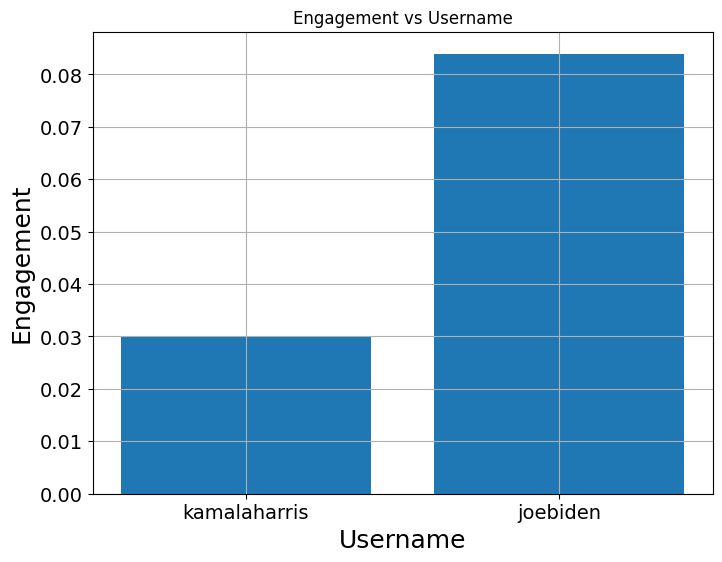

In [33]:
plt.bar(df['username'],df['engagement'])
plt.xlabel('Username')
plt.ylabel('Engagement')
plt.title('Engagement vs Username')
plt.show()

### T-test for engagement

nan

In [34]:
alpha = 0.01  #significance level
col = 'engagement'
w0, w1 = df.username.unique()

print(f"w0 = {w0}\nw1 = {w1}")

X0 = df.loc[df.username==w0, col].values
X1 = df.loc[df.username==w1,col].values

(tstat, pval) =stats.ttest_ind(X0,X1,
                               equal_var = False,
                               nan_policy = 'omit',
                               alternative = 'two-sided')
print(f"{w0} vs {w1}: t-stat = {tstat:.3f} ({pval:.4e})\n")
if pval <=alpha:
  print(f"Significant at {alpha*100:.0f}% level")
else:
  print(f"Not significant at {alpha*100:.0f}% level")

w0 = kamalaharris
w1 = joebiden
kamalaharris vs joebiden: t-stat = 9.436 (1.0346e-20)

Significant at 1% level


### Multiple keywords

Let's see if there is a difference in engagement when either of the users puts a keyword into their tweets.  We will go through a list `keywords`, and for each `keyword`, add a column `"keyword_[keyword]"` to `df`.  Then we will get the engagement for the tweets of each username that have the keyword, call them `X0` and `X1`.  The `usernames` list helps us keep track of whose tweets are whose.   We apply a t-test and save the p-values to a dataframe `df_p`.  Then we can apply a multiple hypothesis test to see which null hypothese we can reject.

Also, while going through the `for` loop, we save the mean engagement for each username and keyword presence combination.  We make this a dataframe `df_plot` that we can use to plot the engagement vs keyword for the two users.

In [41]:
keywords = ['trump', 'biden','harris',
            'america', 'maga']
dict_list = []
dict_list_plot = []
for keyword in keywords:
  col = f"keyword_{keyword}"
  df[col] = df['text'].str.contains(keyword, case=False, regex=True, na=False)
  # Filter for tweets containing the keyword "america"
  df_keyword = df[df[col]]

  # Perform t-test on engagement vs. username for those tweets
  if len(df_keyword) > 1 :
    grouped = df_keyword.groupby('username')['engagement'].agg(['mean', 'std', 'count'])
    if len(grouped) == 2 :
      usernames = df.username.unique()
      X0 = df_keyword[df_keyword['username'] == usernames[0]]['engagement'].dropna().values
      X1 = df_keyword[df_keyword['username'] == usernames[1]]['engagement'].dropna().values
      if len(X0) > 0 and len(X1) > 0:
          t_statistic, pval = stats.ttest_ind(X0, X1,
                                              equal_var=False)
          #add data for doing multiple hypothesis testing
          dict_list.append({'keyword':keyword,
                            'pval':pval})
          #add data for plotting engagement
          dict_list_plot.append({'keyword':keyword,
                                 'username':usernames[0],
                                 'engagement':X0.mean()})
          dict_list_plot.append({'keyword':keyword,
                                 'username':usernames[1],
                                 'engagement':X1.mean()})

      else :
          print("Not enough data points for the T-test.")
    else :
      print("Less than two users with tweets containing the keyword")
  else:
      print(f"No tweets found with the keyword {keyword}")

#make dataframes multitple hypothesis testing and plotting
df_p = pd.DataFrame(dict_list)
df_plot = pd.DataFrame(dict_list_plot)

display(df_p)

,keyword,pval
0,trump,7.717152e-01
1,biden,2.956802e-02
2,harris,3.922854e-01
3,america,1.485207e-11
4,maga,6.912152e-03


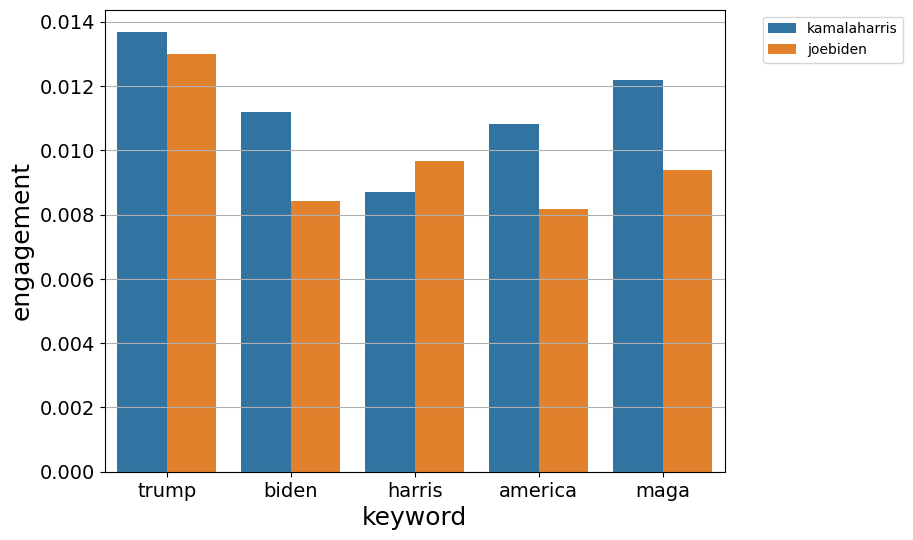

In [42]:
#bar plot engagement vs username and keyword
sns.barplot(data=df_plot, hue='username', y='engagement', x='keyword')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Moves legend outside
plt.show()


In [46]:
alpha = 0.01  #significance level
#multiple testing method, choices are
#'bonferroni', 'sidak', 'holm', or 'fdr_bh'
method = 'bonferroni'
rejects,pvals_corrected,_,_ = multipletests(df_p.pval,
                                            alpha=alpha,
                                            method=method,
                                            is_sorted=False,
                                            returnsorted=False)

df_p['reject_H0'] = rejects
print(f"{method} method")
display(df_p)

bonferroni method


,keyword,pval,reject_H0
0,trump,7.717152e-01,False
1,biden,2.956802e-02,False
2,harris,3.922854e-01,False
3,america,1.485207e-11,True
4,maga,6.912152e-03,False
